<a href="https://colab.research.google.com/github/dpb24/fake-news-detector/blob/main/Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detector: Binary Classification Model

In this project, we analyse the [ISOT Fake News Detection Dataset](https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/) and develop a machine learning model to classify articles as either fake or real. We use the [*scikit-learn*](https://scikit-learn.org/) and [*XGBoost*](https://xgboost.readthedocs.io/) libraries for text preprocessing and model development. Specifically, we build a baseline decision tree model and an ensemble model using eXtreme Gradient Boosting (XGBoost).

This project was developed as part of a technical assessment for a policy-oriented organisation exploring approaches to misinformation detection.

## 1 Imports
We import relevant Python packages for data manipulation, visualisation, preprocessing and modeling.

In [ ]:
# Operational packages
import pandas as pd
import numpy as np
import warnings
import pickle
from datetime import datetime
from google.colab import files

# Visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns

# Text feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Machine Learning models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import plot_importance

# Data preprocessing
from sklearn.model_selection import train_test_split

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings("ignore", category=FutureWarning)

We load the fake and real news articles into pandas DataFrames and assign them to the variables **fake_news** and **real_news**, respectively.

In [ ]:
# Upload token to Kaggle
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 1.15GB/s]
Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
# Download datasets from Kaggle and unzip
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip

In [ ]:
# import data
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv')

## 2 Data Exploration
### 2.1 Initial Exploratory Data Analysis

In [ ]:
# check first 5 rows of fake news dataset
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# check first 5 rows of real news dataset
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# check size of fake news dataset
fake_news.shape

(23481, 4)

In [ ]:
# check size of real news dataset
real_news.shape

(21417, 4)

The fake news dataset contains **23,481** entries, each representing a fake news article. The real news dataset contains **21,417** entries, with each corresponding to a real news article. Both datasets share the same column structure.

### 2.2 Data Cleaning

We combine the real and fake news datasets into a single DataFrame and introduce a new column, **label**, to indicate the class (0 for real news, 1 for fake news).

In [ ]:
# combine datasets
fake_news['label'] = 1
real_news['label'] = 0
news_df = pd.concat([fake_news, real_news], ignore_index=True)

In [ ]:
# check first 5 rows of news dataset
news_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [ ]:
# check last 5 rows of news dataset
news_df.tail()

,title,text,subject,date,label
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0


In [ ]:
# Check size of the new DataFrame
news_df.shape

(44898, 5)

We check the data types of the columns.

In [ ]:
# Check data types of columns
news_df.dtypes

,0
title,object
text,object
subject,object
date,object
label,int64


We convert the **date** column to a pandas *datetime64* type to enable easier time-based filtering.

In [ ]:
# Strip leading/trailing whitespace from all entries in the date column
news_df['date'] = news_df['date'].astype(str).str.strip()

# Convert 'date' column to datetime
def parse_date(text):
    for fmt in ("%d-%b-%y", "%b %d, %Y", "%Y-%m-%d", "%d-%m-%Y", "%d %b %Y", "%B %d, %Y"):
        try:
            return datetime.strptime(text.strip(), fmt)
        except Exception:
            continue
    return pd.NaT

news_df['date_new'] = news_df['date'].apply(parse_date)

# Check data types of columns
news_df.dtypes

,0
title,object
text,object
subject,object
date,object
label,int64
date_new,datetime64[ns]


We check for missing values.

In [ ]:
# Check for missing values
news_df.isna().sum()

title        0
text         0
subject      0
date         0
label        0
date_new    10
dtype: int64

In [ ]:
# Inspect entries with missing values
news_df[news_df['date_new'].isna()][['date', 'date_new']]

,date,date_new
9358,https://100percentfedup.com/served-roy-moore-v...,NaT
15507,https://100percentfedup.com/video-hillary-aske...,NaT
15508,https://100percentfedup.com/12-yr-old-black-co...,NaT
15839,https://fedup.wpengine.com/wp-content/uploads/...,NaT
15840,https://fedup.wpengine.com/wp-content/uploads/...,NaT
17432,https://fedup.wpengine.com/wp-content/uploads/...,NaT
17433,https://fedup.wpengine.com/wp-content/uploads/...,NaT
18933,MSNBC HOST Rudely Assumes Steel Worker Would N...,NaT
21869,https://fedup.wpengine.com/wp-content/uploads/...,NaT
21870,https://fedup.wpengine.com/wp-content/uploads/...,NaT


In [ ]:
# Drop rows with missing 'date_new'
news_df_subset = news_df.dropna(subset=['date_new'])

# Drop the original 'date' column
news_df_subset2 = news_df_subset.drop(columns='date')

# Rename columns
news_df_subset3 = news_df_subset2.rename(columns={
    'title': 'headline',
    'text': 'article_text',
    'subject': 'category',
    'date_new': 'publication_date'})


We check for duplicate entries and remove if necessary.

In [ ]:
# Check for duplicates
news_df_subset3.duplicated().sum()

np.int64(209)

In [ ]:
# Drop duplicates
news_df_subset4 = news_df_subset3.drop_duplicates().reset_index(drop=True)

### 2.3 Label Correlation and Evaluation Design

We explore the values in the **category** column and visualise the distribution by class (real or fake news).

In [ ]:
# Count categories by value
news_df_subset4['category'].value_counts()

category
politicsNews       11220
worldnews           9991
News                9050
politics            6833
left-news           4456
Government News     1568
US_News              783
Middle-east          778
Name: count, dtype: int64

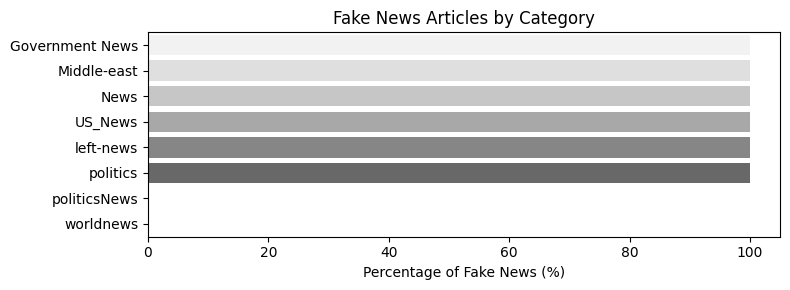

In [ ]:
# Calculate percentage of label=1 for each category
category_percent_fake = news_df_subset4.groupby('category')['label'].mean()*100

# Plot horizontal bar chart
plt.figure(figsize=(8, 3))
sns.barplot(x=category_percent_fake.values, y=category_percent_fake.index, palette='Greys')
plt.xlabel('Percentage of Fake News (%)')
plt.ylabel('')
plt.title('Fake News Articles by Category')
plt.tight_layout()
plt.show()

We observe that **category** has eight distinct values, each perfectly correlated with the target variable **label** (fake vs. real). This artefact reflects the fact that the fake and real news articles were sourced from separate datasets. To enable fair, subject-specific model evaluation without introducing leakage, we consolidate these categories into a broader thematic variable, **domain**, which we will use for stratified performance evaluation of the model.

The mapping is as follows:
* news: *worldnews*, *News*, *US_News*, *Middle-east*
* politics: *politicsNews*, *left-news*, *politics*, *Government News*

In [ ]:
# Define the mapping dictionary
category_to_domain = {
    'worldnews': 'news',
    'News': 'news',
    'US_News': 'news',
    'Middle-east': 'news',
    'politicsNews': 'politics',
    'left-news': 'politics',
    'politics': 'politics',
    'Government News': 'politics'
}

# Create the new 'domain' column by mapping the 'category' values
news_df_subset4['domain'] = news_df_subset4['category'].map(category_to_domain).fillna('other')


### 2.4 Temporal Distribution Analysis

We plot a histogram to visualise the temporal distribution of the fake and real news articles.

Fake news articles range from 2015-03-31 to 2018-02-19
Real news articles range from 2016-01-13 to 2017-12-31


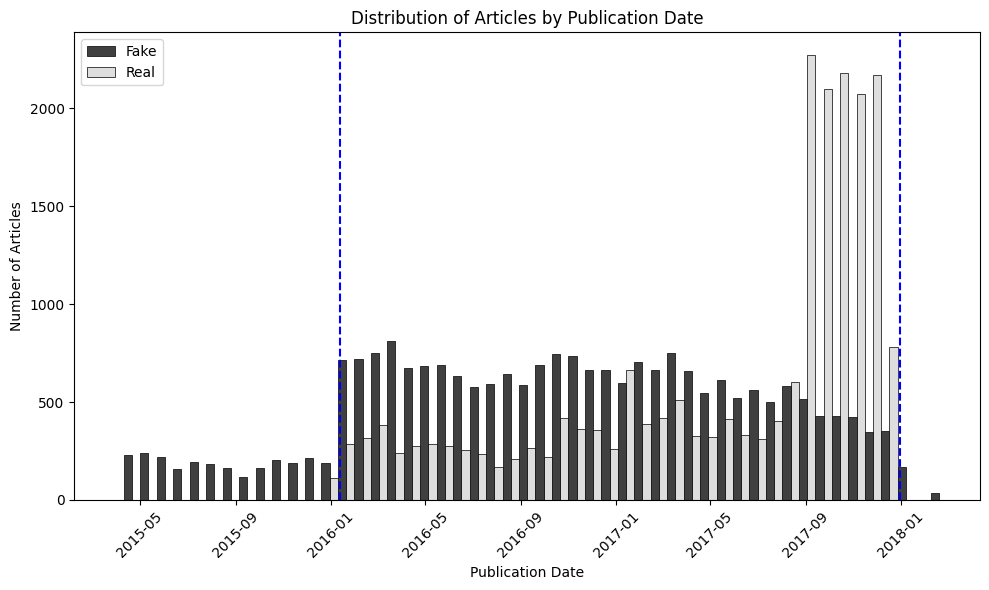

In [ ]:
# Earliest and latest publication dates for fake news
fake_min = news_df_subset4[news_df_subset4['label'] == 1]['publication_date'].min()
fake_max = news_df_subset4[news_df_subset4['label'] == 1]['publication_date'].max()
print(f"Fake news articles range from {fake_min.date()} to {fake_max.date()}")

# Earliest and latest publication dates for real news
real_min = news_df_subset4[news_df_subset4['label'] == 0]['publication_date'].min()
real_max = news_df_subset4[news_df_subset4['label'] == 0]['publication_date'].max()
print(f"Real news articles range from {real_min.date()} to {real_max.date()}")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=news_df_subset4,
    x='publication_date',
    hue='label',
    bins=50,
    multiple='dodge',
    palette={1: 'black', 0: 'lightgrey'}
    )
plt.title('Distribution of Articles by Publication Date')
plt.xlabel('Publication Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(labels=['Fake', 'Real'])
plt.axvline(real_min, color='blue', linestyle='--', linewidth=1.5)
plt.axvline(real_max, color='blue', linestyle='--', linewidth=1.5)
plt.tight_layout()

# Save to file
plt.savefig("distribution of articles by publication date.png", dpi=300)

# Show the plot
plt.show()

We exclude articles published outside of the range **2016-01-13** and **2017-12-31** to ensure representation of both classes throughout publication period. This filtering is based on the assumption that publication date affects the content of real news articles, if not that of fake news.

We observe that while real news is generally under-represented before September 2017 and significantly over-represented afterward, the filtered dataset maintains overall class balance with a total of **41,754** news articles (**50.7%** real and **49.2%** fake).

In [ ]:
# Filter out articles published before 2016-01-13 and after 2017-12-31
news_df_subset5 = news_df_subset4[
    (news_df_subset4['publication_date'] >= '2016-01-13') &
    (news_df_subset4['publication_date'] <= '2017-12-31')
    ].copy()

# total number of articles in filtered dataset
print(f"Total number of articles in filtered dataset: {news_df_subset5.shape[0]}")

# % of fake and real news articles in filtered dataset
news_df_subset5['label'].value_counts() / news_df_subset5.shape[0] * 100

Total number of articles in filtered dataset: 41754


label
0    50.799923
1    49.200077
Name: count, dtype: float64

### 2.5 Feature Engineering
#### 2.5.1 Text feature extraction

The text from news articles cannot be directly used in machine learning algorithms and must first be transformed into numerical feature vectors. We adopt the Bag of Words (BoW) representation - one of the simplest Natural Language Processing (NLP) techniques - which captures the frequency of words across the training dataset.

To inform our choice of vocabulary size, we compute the average number of words per article.

In [ ]:
# Add word count columns
news_df_subset5['headline_word_count'] = news_df_subset5['headline'].str.split().str.len()
news_df_subset5['article_word_count'] = news_df_subset5['article_text'].str.split().str.len()

# Calculate mean word count
mean_headline_word_count = news_df_subset5['headline_word_count'].mean()
mean_article_word_count = news_df_subset5['article_word_count'].mean()

print(f"Mean headline word count: {mean_headline_word_count} words")
print(f"Mean article word count:  {mean_article_word_count} words")

Mean headline word count: 12.261268381472433 words
Mean article word count:  403.0125257460363 words


We use the *scikit-learn* machine learning library to implement the Bag of Words feature extraction. Assuming that our fake news detector will be deployed exclusively on English-language articles, we configure the *CountVectorizer* to exclude words from its built-in list of English stop words (eg. "and", "the").

Given the relatively short length of the articles in the dataset (an average of 415 words), we limit the vocabulary to the 2,000 most frequent non-stop words in order to control dimensionality and improve training efficiency. This limit could be later increased — for example, to 5,000 features — to potentially enhance model performance, subject to computational constraints.

In [ ]:
# Create new column combined headline and article text
news_df_subset5['combined_text'] = news_df_subset5['headline'] + ' ' + news_df_subset5['article_text']

# Create CountVectorizer Object
vectorizer = CountVectorizer(stop_words='english', max_features=2000)

# Fit and transform the text
vectorized_text = vectorizer.fit_transform(news_df_subset5['combined_text'])

# Convert to vectorized text to DataFrame
vectorized_text_df = pd.DataFrame(vectorized_text.toarray(), columns=vectorizer.get_feature_names_out())

# Check shape of vectorized text DataFrame
vectorized_text_df.shape

(41754, 2000)

In [ ]:
# Check shape of pre-vectorized text DataFrame
news_df_subset5.shape

(41754, 9)

In [ ]:
# Align indexes of BoW and original DataFrame
news_df_subset5 = news_df_subset5.reset_index(drop=True)
vectorized_text_df = vectorized_text_df.reset_index(drop=True)

# Create masks
mask_real = news_df_subset5['label'] == 0
mask_fake = news_df_subset5['label'] == 1

# Apply masks to the BoW dataframe
real_bow = vectorized_text_df[mask_real]
fake_bow = vectorized_text_df[mask_fake]

In [ ]:
# Sum each column to get total word counts across all real articles
real_bow_totals = real_bow.sum(axis=0)
fake_bow_totals = fake_bow.sum(axis=0)

# Convert the Series to a DataFrame
real_bow_totals_df = real_bow_totals.reset_index()
real_bow_totals_df.columns = ['word', 'total_count']
fake_bow_totals_df = fake_bow_totals.reset_index()
fake_bow_totals_df.columns = ['word', 'total_count']

# Join the two DataFrames
combined_bow_totals_df = pd.merge(
    real_bow_totals_df,
    fake_bow_totals_df,
    on='word',
    how='inner',
    suffixes=('_real', '_fake')
)

# Sort the DataFrames by total_count
real_bow_totals_df = real_bow_totals_df.sort_values(by='total_count', ascending=False)
fake_bow_totals_df = fake_bow_totals_df.sort_values(by='total_count', ascending=False)


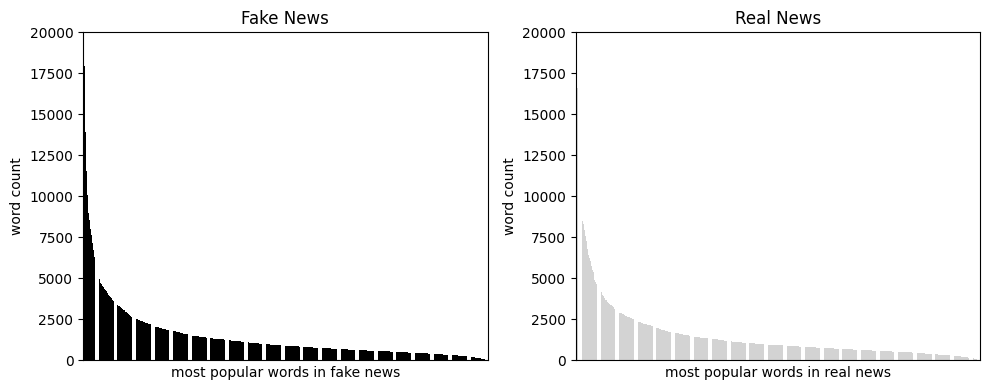

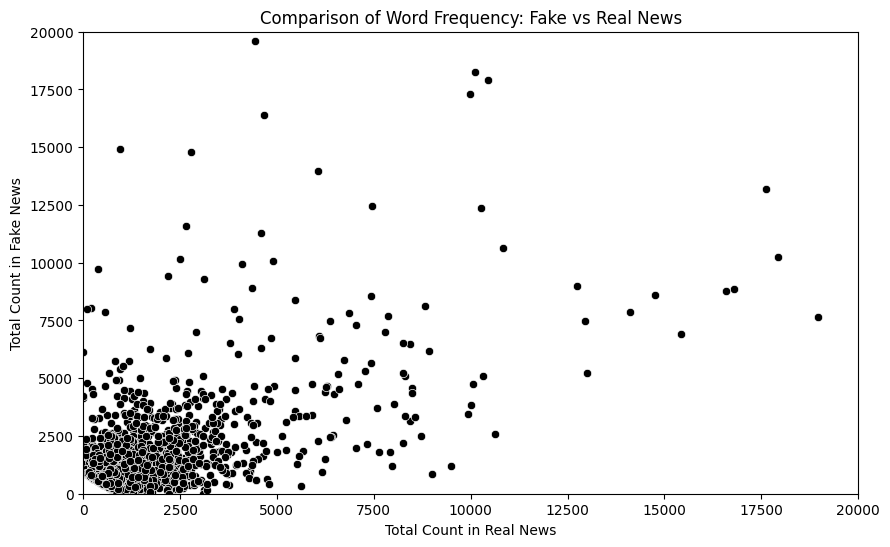

   Top 5 words in fake news         Top 5 words in real news
------------------------------------------------------------
1             trump                           said             
2              said                          trump             
3           president                       reuters            
4             people                       president           
5              just                          state             


In [ ]:
# Create the figure
plt.figure(figsize=(10, 4))

# Plot first bar chart
plt.subplot(1, 2, 1)

sns.barplot(
    data=fake_bow_totals_df,
    x='word',
    y='total_count',
    color='black'
)
plt.xlabel('most popular words in fake news')
plt.gca().xaxis.set_ticks([])
plt.ylabel('word count')
plt.ylim(0, 20000)
plt.title('Fake News')

# Plot second bar chart
plt.subplot(1, 2, 2)

sns.barplot(
    data=real_bow_totals_df,
    x='word',
    y='total_count',
    color='lightgrey'
)
plt.xlabel('most popular words in real news')
plt.gca().xaxis.set_ticks([])
plt.ylabel('word count')
plt.ylim(0, 20000)
plt.title('Real News')
plt.tight_layout()

# Save to file
plt.savefig("bow representation - distribution of most popular words.png", dpi=300)

# Show the plot
plt.show()

# Plot third chart
plt.figure(figsize=(10, 6))
sns.scatterplot(
        data=combined_bow_totals_df,
        x='total_count_real',
        y='total_count_fake',
        color='black'
        )
plt.xlabel('Total Count in Real News')
plt.ylabel('Total Count in Fake News')
plt.xlim(0, 20000)
plt.ylim(0, 20000)
plt.title('Comparison of Word Frequency: Fake vs Real News')

# Save to file
plt.savefig("bow representation - fake vs real news.png", dpi=300)

# Show the plot
plt.show()

# display the top 5 words in fake and real news
print('   Top 5 words in fake news         Top 5 words in real news')
print('------------------------------------------------------------')
for i in range(5):
    print(f"{i+1} {fake_bow_totals_df.iloc[i]['word']:^30} {real_bow_totals_df.iloc[i]['word']:^30}")

We observe that the distribution of frequently occurring words in fake news articles closely resembles that of real news articles, with both sharing key terms among their top five most frequent words. However, the scatterplot reveals a clear distinction between the two classes when considering the full 2,000-word Bag of Words representation.

We note that *scikit-learn*'s *CountVectorizer* removes punctuation and special characters, and converts all text to lowercase by default, which can obscure stylistic and structural cues in the original text. Therefore, to recover information potentially lost during the Bag of Words transformation, we incorporate several additional engineered features.


#### 2.5.2 Additional Engineered Features

##### 2.5.2.1 Text length

We plot the distribution of headline and article word count to examine correlations with the target class.

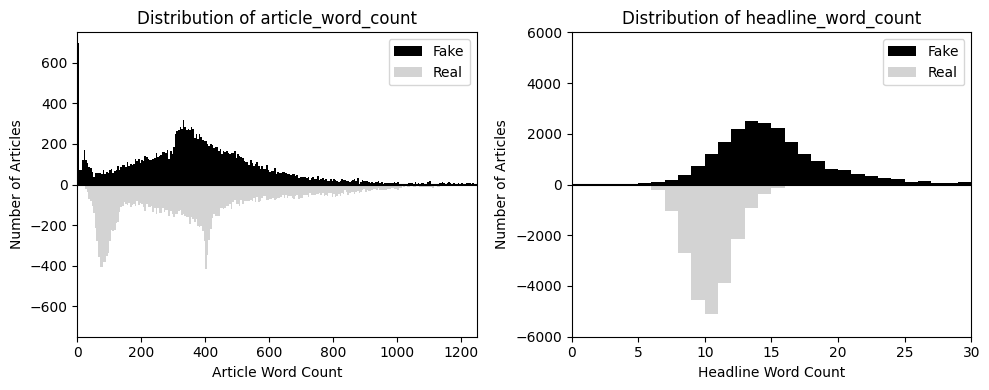

In [ ]:
# Create the figure
plt.figure(figsize=(10, 4))

# Plot first histogram
plt.subplot(1, 2, 1)

real_word_counts = news_df_subset5[news_df_subset5['label'] == 0]['article_word_count']
fake_word_counts = news_df_subset5[news_df_subset5['label'] == 1]['article_word_count']

bins = np.linspace(0, 1250, 251)
real_counts, _ = np.histogram(real_word_counts, bins=bins)
fake_counts, _ = np.histogram(fake_word_counts, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = bins[1] - bins[0]

plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')
plt.xlabel('Article Word Count')
plt.ylabel('Number of Articles')
plt.title('Distribution of article_word_count')
plt.xlim(0, 1250)
plt.ylim(-750, 750)
plt.axhline(0, color='black')
plt.legend()

# Plot second histogram
plt.subplot(1, 2, 2)

real_word_counts = news_df_subset5[news_df_subset5['label'] == 0]['headline_word_count']
fake_word_counts = news_df_subset5[news_df_subset5['label'] == 1]['headline_word_count']

bins = np.arange(0, 31, 1)
real_counts, _ = np.histogram(real_word_counts, bins=bins)
fake_counts, _ = np.histogram(fake_word_counts, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = 1

plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('Headline Word Count')
plt.ylabel('Number of Articles')
plt.title('Distribution of headline_word_count')
plt.xlim(0, 30)
plt.ylim(-6000, 6000)
plt.axhline(0, color='black')
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig("distribution of word count.png", dpi=300)

# Show the plot
plt.show()

We observe limited variation in the distributions of **article_word_count** and **headline_word_count** between the two classes.

##### 2.5.2.2 Special Characters
We create columns to quantify the percentage of special characters in the headline and article text, then plot their distribution to examine correlations with the target class.

In [ ]:
# Define special characters
special_chars = r'[!@£$%^&*()]'

# Add character count columns
news_df_subset5['headline_chars_count'] = news_df_subset5['headline'].str.len()
news_df_subset5['article_chars_count'] = news_df_subset5['article_text'].str.len()

# Calculate % of special characters in headline
news_df_subset5['headline_special_chars'] = news_df_subset5['headline'].str.count(special_chars) / news_df_subset5['headline_chars_count'] * 100

# Calculate % of special characters in article text
news_df_subset5['article_special_chars'] = news_df_subset5['article_text'].str.count(special_chars) / news_df_subset5['article_chars_count'] * 100

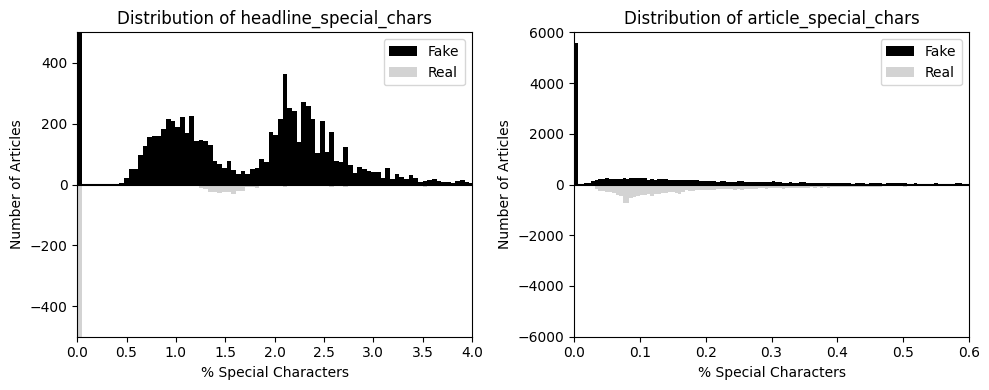

In [ ]:
# Create the figure
plt.figure(figsize=(10, 4))

# Plot first histogram
plt.subplot(1, 2, 1)

real_spec_char_counts = news_df_subset5[news_df_subset5['label'] == 0]['headline_special_chars']
fake_spec_char_counts = news_df_subset5[news_df_subset5['label'] == 1]['headline_special_chars']

num_bins = 200
combined = np.concatenate([real_spec_char_counts, fake_spec_char_counts])
bins = np.linspace(combined.min(), combined.max(), num_bins + 1)
real_counts, _ = np.histogram(real_spec_char_counts, bins=bins)
fake_counts, _ = np.histogram(fake_spec_char_counts, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = np.diff(bins)[0]

plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('% Special Characters')
plt.ylabel('Number of Articles')
plt.title('Distribution of headline_special_chars')
plt.xlim(0, 4)
plt.ylim(-500, 500)
plt.axhline(0, color='black')
plt.legend()

# Plot second histogram
plt.subplot(1, 2, 2)

real_spec_char_counts = news_df_subset5[news_df_subset5['label'] == 0]['article_special_chars']
fake_spec_char_counts = news_df_subset5[news_df_subset5['label'] == 1]['article_special_chars']

num_bins = 5000
combined = np.concatenate([real_spec_char_counts, fake_spec_char_counts])
bins = np.linspace(combined.min(), combined.max(), num_bins + 1)

real_counts, _ = np.histogram(real_spec_char_counts, bins=bins)
fake_counts, _ = np.histogram(fake_spec_char_counts, bins=bins)

bin_centers = (bins[:-1] + bins[1:]) / 2
width = np.diff(bins)[0]

plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('% Special Characters')
plt.ylabel('Number of Articles')
plt.title('Distribution of article_special_chars')
plt.xlim(0, 0.6)
plt.ylim(-6000, 6000)
plt.axhline(0, color='black')
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig("distribution of special characters.png", dpi=300)

# Show the plot
plt.show()

We observe a notable difference in the distribution of **headline_special_chars** between the two classes, suggesting that this could be a valuable engineered feature for distinguishing between fake and real news.

##### 2.5.2.3 Capitalised Characters
We create columns to quantify the percentage of capitalised characters in the headline and article text, then plot their distribution to examine correlations with the target class.

In [ ]:
# Calculate % of capitalised characters in headline
news_df_subset5['headline_capitalised'] = (news_df_subset5['headline'].str.count(r'[A-Z]') / news_df_subset5['headline_chars_count']) * 100

# Calculate % of capitalised characters in article text
news_df_subset5['article_capitalised'] = (news_df_subset5['article_text'].str.count(r'[A-Z]') / news_df_subset5['article_chars_count']) * 100

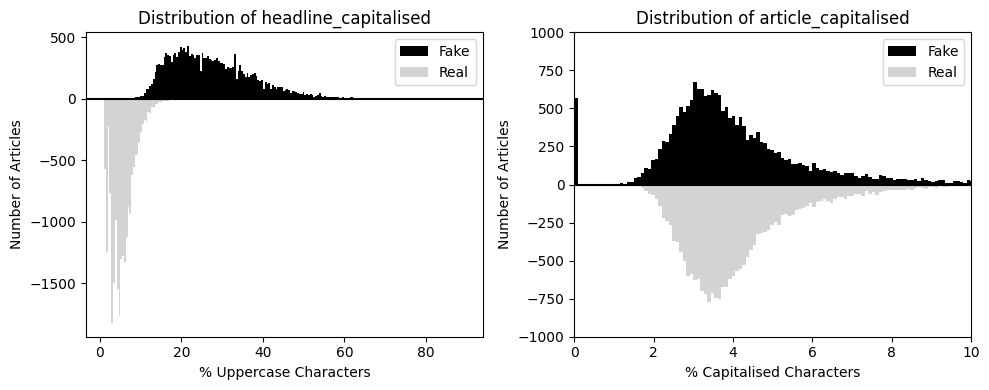

In [ ]:
# Create the figure
plt.figure(figsize=(10, 4))

# Plot first histogram
plt.subplot(1, 2, 1)

real_capitalised = news_df_subset5[news_df_subset5['label'] == 0]['headline_capitalised']
fake_capitalised = news_df_subset5[news_df_subset5['label'] == 1]['headline_capitalised']

num_bins = 200
combined = np.concatenate([real_capitalised, fake_capitalised])
bins = np.linspace(combined.min(), combined.max(), num_bins + 1)
real_counts, _ = np.histogram(real_capitalised, bins=bins)
fake_counts, _ = np.histogram(fake_capitalised, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = np.diff(bins)[0]

plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('% Uppercase Characters')
plt.ylabel('Number of Articles')
plt.title('Distribution of headline_capitalised')
plt.axhline(0, color='black')
plt.legend()

# Plot second histogram
plt.subplot(1, 2, 2)

real_capitalised = news_df_subset5[news_df_subset5['label'] == 0]['article_capitalised']
fake_capitalised = news_df_subset5[news_df_subset5['label'] == 1]['article_capitalised']

num_bins = 1000
combined = np.concatenate([real_capitalised, fake_capitalised])
bins = np.linspace(combined.min(), combined.max(), num_bins + 1)
real_counts, _ = np.histogram(real_capitalised, bins=bins)
fake_counts, _ = np.histogram(fake_capitalised, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = np.diff(bins)[0]

plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('% Capitalised Characters')
plt.ylabel('Number of Articles')
plt.title('Distribution of article_capitalised')
plt.xlim(0, 10)
plt.ylim(-1000, 1000)
plt.axhline(0, color='black')
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig("distribution of uppercase characters.png", dpi=300)

# Show the plot
plt.show()

We observe notable differences in the distribution of **headline_capitalised** between the two classes, suggesting that this could be another valuable engineered feature for the classification model.

## 3 Model Construction

We build two machine learning models to classify articles: a single Decision Tree as a baseline, and an XGBoost Decision Tree Ensemble model.

The single Decision Tree model is fast to train and highly interpretable, making it an ideal starting point for baseline evaluation. However, it is prone to overfitting and generally offers lower predictive performance compared to more advanced models.

The XGBoost Decision Tree Ensemble model is highly scalable and efficient to implement, making it suitable for both small and large datasets. It has built-in regularisation to prevent overfitting and improve robustness and generally offers highly competitve performance. However its interpretability is lower than that of a single decision tree.

### 3.1 Final Feature Selection

The models will be trained on a combined feature set comprising both text-based representations (Bag of Words) and selected engineered numerical features. To ensure model efficiency, we include only those engineered features that exhibited meaningful class separation during exploratory analysis.

| Target ($y$)                      | Features ($x_i$)|
|---------------------------------------------|----------------------------------------|
| **label** (0 = real, 1 = fake) |  Bag of Words vectorized text representation  |
|                 |  **headline_special_chars** (numeric)  |
|                 |  **headline_capitalised** (numeric)    |

### 3.2 Split the data
We define the target variable and isolate the selected features to prepare the dataset for model training and evaluation.

In [ ]:
# Assign target variable
y = news_df_subset5['label']

# Select engineered numeric features as a DataFrame
engineered_features = news_df_subset5[['headline_special_chars', 'headline_capitalised']]

# Combine vectorized text features and engineered numeric features
X = pd.concat([vectorized_text_df.reset_index(drop=True), engineered_features.reset_index(drop=True)], axis=1)


We split the data into training, validation and test sets, 60/20/20.

In [ ]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((25052, 2002), (8351, 2002), (8351, 2002), (25052,), (8351,), (8351,))

### 3.3 Build Models
#### 3.3.1 Decision Tree

We employ the [*DecisionTreeClassifier*](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from the *scikit-learn* library to fit a single decision tree classification model to the training dataset. Hyperparameters are tuned using [*GridSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), with the best model selected based on the $F_1$ score - which is defined as the harmonic mean of Precision ($P$) and Recall ($R$).

$F_1 = 2 \cdot \frac{P \cdot R}{P + R}$

In [ ]:
# Instantiate the decision tree classifier
dt = DecisionTreeClassifier(random_state=0)

# Create a dictionary of hyperparameters to search over
cv_params = {'max_depth': [5, 7, None],
             'max_features': ['sqrt', 0.3, 0.6],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 3],
             }

# Define scoring metrics for classification
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object for cross-validation
dt_cv = GridSearchCV(
    estimator=dt,
    param_grid=cv_params,
    scoring=scoring,
    cv=5,
    refit='f1',
    return_train_score=True
    )

In [ ]:
%%time
# Fit the model to the training data
dt_cv.fit(X_train, y_train)

CPU times: user 2min 51s, sys: 1min 27s, total: 4min 19s
Wall time: 4min 21s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None],
                         'max_features': ['sqrt', 0.3, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1'])

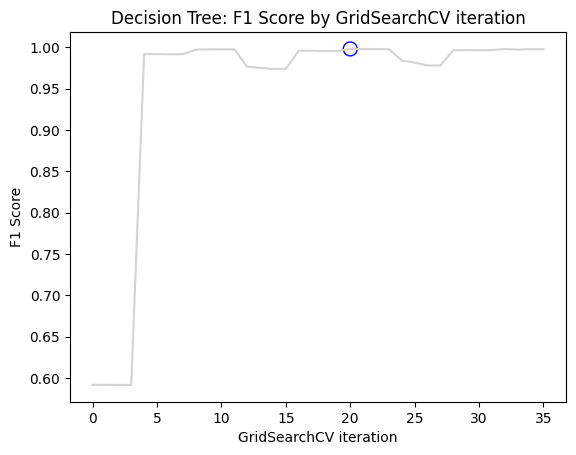

Best F1 score: 0.9981 found on GridSearchCV iteration 21 of 36, with these Decision Tree model parameters:
{'max_depth': 7, 'max_features': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Access the GridSearchCV results and convert to a DataFrame
dt_results_df = pd.DataFrame(dt_cv.cv_results_)

# Create a line plot of F1 score by GridSearchCV iteration
sns.lineplot(data=dt_results_df, x=dt_results_df.index, y='mean_test_f1', color='lightgrey')
plt.title('Decision Tree: F1 Score by GridSearchCV iteration')
plt.xlabel('GridSearchCV iteration')
plt.ylabel('F1 Score')
best_iter = dt_results_df['mean_test_f1'].idxmax()
best_score = dt_results_df.loc[best_iter, 'mean_test_f1']
plt.scatter(best_iter, best_score, s=100, facecolors='none', edgecolors='blue', linewidths=1)

# Save to file
plt.savefig("decision tree - f1 score by iteration.png", dpi=300)

# Show the plot
plt.show()

# Display results
print(
    f"Best F1 score: {dt_cv.best_score_:.4f} found on GridSearchCV iteration {best_iter + 1} "
    f"of {dt_results_df.shape[0]}, with these Decision Tree model parameters:"
)
print(dt_cv.best_params_)

The best-performing single decision tree model identified via *GridSearchCV* on the training dataset is constrained to a maximum depth of **7** levels. This limitation controls the model’s complexity and helps mitigate overfitting. At each split, the algorithm randomly considers **60%** of the available features, introducing beneficial randomness that can improve generalisation. The minimum number of samples required to form a leaf node is set to **1**, which permits leaves to contain very few samples and may increase the risk of overfitting. Furthermore, each internal node must have at least **2** samples to be eligible for splitting—this minimum value allows maximal growth of the tree within the given constraints. With these parameters, the single decision tree model achieved an $F_1$ score of **0.9981** on the training dataset.

#### 3.3.2 XGBoost Ensemble

We employ the [*XGBClassifier*](https://xgboost.readthedocs.io/en/latest/python/python_api.html) from the *XGBoost* library to fit an ensemble of decision trees using Extreme Gradient Boosting (XGBoost) to the training dataset. To reduce computational overhead, hyperparameters are tuned using [*RandomizedSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), with model selection based on maximising the $F_1$ score, consistent with our earlier approach.

In [ ]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(random_state=0, eval_metric='logloss')

# Create a dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Define scoring metric for RandomizedSearchCV
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the RandomizedSearchCV object for cross-validation
xgb_cv = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=cv_params,
    scoring=scoring,
    cv=5,
    refit='f1',
    n_iter=50,
    random_state=0,
    n_jobs=-1
)

In [ ]:
%%time
# Fit the model to the training data
xgb_cv.fit(X_train, y_train)

CPU times: user 1min 10s, sys: 9 s, total: 1min 19s
Wall time: 39min 11s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=0, refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

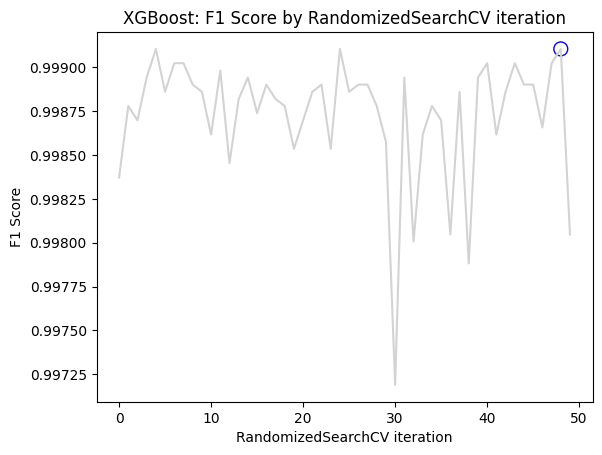

Best F1 score: 0.9991 found on RandomizedSearchCV iteration 49 of 50, with these Decision Tree Ensemble XGBoost model parameters:
{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.2}


In [ ]:
# Access the GridSearch results and convert it to a pandas df
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)

# Create a line plot of F1 score by RandomizedSearchCV iteration
sns.lineplot(data=xgb_results_df, x=xgb_results_df.index, y='mean_test_f1', color='lightgrey')
plt.title('XGBoost: F1 Score by RandomizedSearchCV iteration')
plt.xlabel('RandomizedSearchCV iteration')
plt.ylabel('F1 Score')
best_iter = xgb_results_df['mean_test_f1'].idxmax()
best_score = xgb_results_df.loc[best_iter, 'mean_test_f1']
plt.scatter(best_iter, best_score, s=100, facecolors='none', edgecolors='blue', linewidths=1)

# Save to file
plt.savefig("xgboost - f1 score by iteration.png", dpi=300)

# Show the plot
plt.show()

# Display results
print(
    f"Best F1 score: {xgb_cv.best_score_:.4f} found on RandomizedSearchCV iteration {best_iter + 1} "
    f"of {xgb_results_df.shape[0]}, with these Decision Tree Ensemble XGBoost model parameters:"
)
print(xgb_cv.best_params_)

The best-performing XGBoost model identified via *RandomizedSearchCV* achieved an $F_1$ score of **0.9991** on the training dataset. This ensemble model comprises **100** decision trees, each constrained to a maximum depth of **7**, which balances model complexity and overfitting risk. A learning rate of **0.2** controls the contribution of each tree to the final prediction, allowing for moderately aggressive updates while retaining stability. The subsample parameter is set to **1.0**, meaning each tree is trained on the full training dataset, potentially improving accuracy at the expense of generalisation. Additionally, the minimum child weight — the minimum sum of instance weights required in a child node — is set to **2**, which can prevent overly specific splits and promote robustness.

## 4 Model Evaluation
### 4.1 Feature Importance Analysis
#### 4.1.1 Decision Tree
We use the *scikit-learn* library's *feature_importances* attribute to conduct an initial analysis of the features identified by the decision tree model as the most predictive.

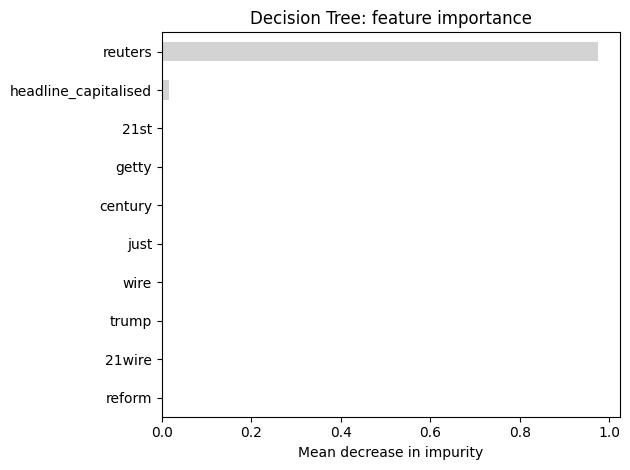

reuters                 0.974837
headline_capitalised    0.016679
21st                    0.001640
getty                   0.001436
century                 0.000784
dtype: float64

In [ ]:
# Feature importance
importances = dt_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns)
top_10_importances = rf_importances.sort_values(ascending=False).head(10)
top_10_importances_sorted = top_10_importances.sort_values(ascending=True)

fig, ax = plt.subplots()
top_10_importances_sorted.plot.barh(ax=ax, color='lightgrey')
ax.set_title('Decision Tree: feature importance')
ax.set_xlabel('Mean decrease in impurity')
fig.tight_layout()

# Save to file
plt.savefig("decision tree - feature importance.png", dpi=300)

# Show the plot
plt.show()

# Display the top 10 feature importances
top_10_importances.head()


For a decision tree, impurity measures how mixed the classes (fake/real) are at a given node. We observe that the Bag of Words feature *reuters* is by far the most important, producing a mean decrease in impurity of **0.975**, indicating that this single feature dominates the splitting decisions.

Our earlier analysis identified reuters as the third most frequent word in the 'real' articles, likely because many 'real' news pieces in the dataset originate from Reuters. While this feature is informative in the context of this specific dataset, its prominence raises concerns about overfitting. To develop a model with broader applicability, removing or down-weighting such dataset-specific cues would likely improve generalisability.

Our engineered feature **headline_capitalised** is the second most influential, but at a substantially lower level—accounting for a reduction of only **0.017** in impurity.

#### 4.1.2 XGBoost Ensemble
We use the *XGBoost* library's *plot_importance* function to conduct an initial analysis of the features selected by the model as the most predictive.

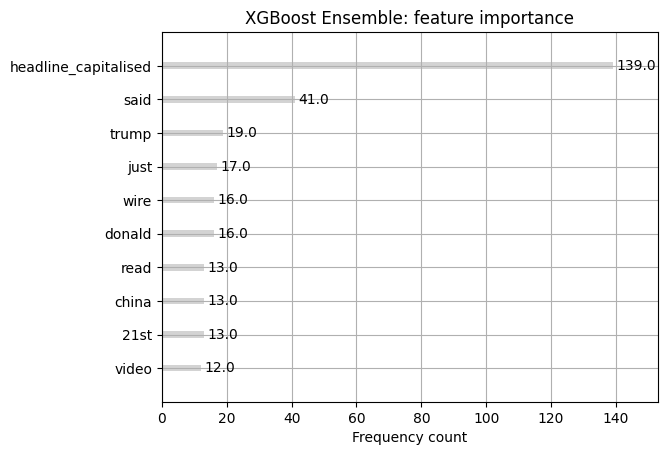

In [ ]:
# Feature importance of XGBoost ensemble
plot_importance(
    xgb_cv.best_estimator_,
    max_num_features=10,
    xlabel='Frequency count',
    ylabel=None,
    color='lightgrey',
    title='XGBoost Ensemble: feature importance')

# Save to file
plt.savefig("xgboost - feature importance.png", dpi=300)

# Show the plot
plt.show()

For the XGBoost ensemble, we observe that the engineered feature **headline_capitalised** is the most influential, having been used **152** times to split nodes across the trees in the ensemble. This aligns with our earlier exploratory analysis, which identified a strong correlation between this feature and the target classes.

Similarly, the Bag of Words feature *reuters* is also prominent, ranking second with 61 splits across the ensemble's trees. As previously noted, this dataset-specific artefact is considered a limitation, as it may hinder the model’s ability to generalise beyond this particular dataset.

### 4.3 Model Retraining Following Removal of Dataset-Specific Features
To address concerns about generalisability, we remove the term *reuters* — a dataset-specific artefact — from the Bag of Words representation.

In [ ]:
# Extend the standard stop words
custom_stop_words = list(ENGLISH_STOP_WORDS.union({'reuters'}))

# Create CountVectorizer Object
vectorizer = CountVectorizer(stop_words=custom_stop_words, max_features=2000)

# Fit and transform the text
vectorized_text = vectorizer.fit_transform(news_df_subset5['combined_text'])

# Convert to vectorized text to DataFrame
vectorized_text_df = pd.DataFrame(vectorized_text.toarray(), columns=vectorizer.get_feature_names_out())

# Combine vectorized text features and engineered numeric features
X = pd.concat([vectorized_text_df.reset_index(drop=True), engineered_features.reset_index(drop=True)], axis=1)


In [ ]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((25052, 2002), (8351, 2002), (8351, 2002), (25052,), (8351,), (8351,))

We retrain both models with the revised training set.

In [ ]:
%%time
# Fit the decision tree model to the training data
dt_cv.fit(X_train, y_train)

CPU times: user 3min 34s, sys: 1min 32s, total: 5min 6s
Wall time: 5min 17s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None],
                         'max_features': ['sqrt', 0.3, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [ ]:
%%time
# Fit the XGBoost ensemble model to the training data
xgb_cv.fit(X_train, y_train)

CPU times: user 2min 1s, sys: 6.71 s, total: 2min 8s
Wall time: 37min 23s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=0, refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

In [ ]:
# Display results
print(
    " Decision Tree classifier:\n",
    f"Best F1 score: {dt_cv.best_score_:.4f} found on GridSearchCV iteration {best_iter + 1}",
    f"of {dt_results_df.shape[0]}, with these Decision Tree model parameters:\n",
    dt_cv.best_params_
    )

print(
    "\n",
    "XGBoost ensemble classifier: \n",
    f"Best F1 score: {xgb_cv.best_score_:.4f} found on RandomizedSearchCV iteration {best_iter + 1}",
    f"of {xgb_results_df.shape[0]}, with these Decision Tree Ensemble XGBoost model parameters:\n",
    xgb_cv.best_params_
    )

 Decision Tree classifier:
 Best F1 score: 0.9930 found on GridSearchCV iteration 21 of 36, with these Decision Tree model parameters:
 {'max_depth': None, 'max_features': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 3}

 XGBoost ensemble classifier: 
 Best F1 score: 0.9980 found on RandomizedSearchCV iteration 21 of 50, with these Decision Tree Ensemble XGBoost model parameters:
 {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.3}


We repeat our feature importance analysis.

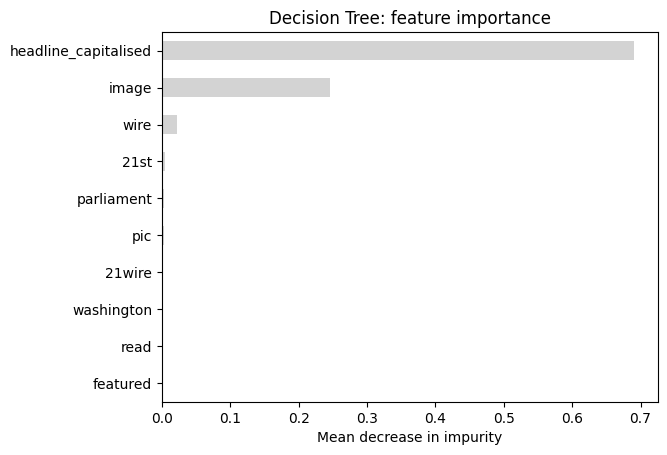

In [ ]:
# Feature importance of decision tree
importances = dt_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns)
top_10_importances = rf_importances.sort_values(ascending=False).head(10)
top_10_importances_sorted = top_10_importances.sort_values(ascending=True)

fig, ax = plt.subplots()
top_10_importances_sorted.plot.barh(ax=ax, color='lightgrey')
ax.set_title('Decision Tree: feature importance')
ax.set_xlabel('Mean decrease in impurity')

# Save to file
plt.savefig("decision tree v2 - feature importance.png", dpi=300)

# Show the plot
plt.show()

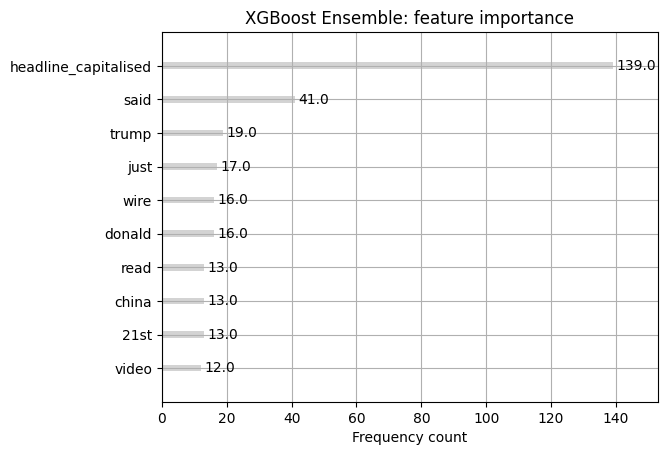

In [ ]:
# Feature importance of XGBoost ensemble
plot_importance(
    xgb_cv.best_estimator_,
    max_num_features=10,
    xlabel='Frequency count',
    ylabel=None,
    color='lightgrey',
    title='XGBoost Ensemble: feature importance')

# Save to file
plt.savefig("xgboost v2 - feature importance.png", dpi=300)

# Show the plot
plt.show()

### 4.4 Model selection
We evaluate the two models on the validation set using standard classification metrics: accuracy, precision, recall, and $F_1$ score.

$A = \frac{\text{True Positives} + \text{True Negatives}}{\text{True Positives} + \text{False Positives} + \text{True Negatives} + \text{False Negatives}}$

$P = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$

$R = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$

$F_1 = 2 \cdot \frac{P \cdot R}{P + R}$

We assess overall model performance across all domains, as well as performance stratified by domain to examine consistency across different types of article content.

In [ ]:
# Subset X_val and y_val using masks
mask_news     = news_df_subset5.loc[X_val.index, 'domain'] == 'news'
mask_politics = news_df_subset5.loc[X_val.index, 'domain'] == 'politics'

X_val_news     = X_val.loc[mask_news]
y_val_news     = y_val.loc[mask_news]
X_val_politics = X_val.loc[mask_politics]
y_val_politics = y_val.loc[mask_politics]

In [ ]:
# Function to calculate evaluation metrics
def get_model_metrics(model, X_data, y_data):
    y_pred = model.predict(X_data)

    accuracy = accuracy_score(y_data, y_pred)
    precision = precision_score(y_data, y_pred, zero_division=0)
    recall = recall_score(y_data, y_pred, zero_division=0)
    f1 = f1_score(y_data, y_pred, zero_division=0)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
        }
    return metrics

# Machine Learning models
models = {
    "Decision Tree": dt_cv.best_estimator_,
    "XGBoost": xgb_cv.best_estimator_
}

# Domains and corresponding subsets
domain_subsets = {
    "all": (X_val, y_val),
    "news": (X_val_news, y_val_news),
    "politics": (X_val_politics, y_val_politics),
}

# Create an empty list to store metrics for each model and domain
results = []

# Loop over each domain subset and each model to calculate metrics
for domain_name, (X_sub, y_sub) in domain_subsets.items():
    for model_name, model in models.items():
        metrics = get_model_metrics(model, X_sub, y_sub)
        metrics["Model"] = model_name
        metrics["Domain"] = domain_name
        results.append(metrics)

# Convert list of results into a DataFrame
results_df = pd.DataFrame(results)

# Reorder columns
results_df = results_df[["Model", "Domain", "Accuracy", "Precision", "Recall", "F1 Score"]]

# Display results
results_df

,Model,Domain,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,all,0.991857,0.990263,0.993164,0.991711
1,XGBoost,all,0.999401,0.999756,0.999023,0.999389
2,Decision Tree,news,0.992802,0.993726,0.992289,0.993007
3,XGBoost,news,0.999255,0.999518,0.999036,0.999277
4,Decision Tree,politics,0.990976,0.986739,0.994062,0.990387
5,XGBoost,politics,0.999537,1.000000,0.999010,0.999505


As anticipated, the XGBoost ensemble demonstrates superior performance across all evaluated metrics - accuracy, precision, recall, and $F_1$ score - making it the best-performing model in this study.

Notably the XGBoost ensemble achieves an aceptionally high $F_1$ score of **0.9999** on the validation set, even surpassing its performance on the training data. This suggests a robust model and may indicate that the validation set is, on average, easier to classify.

No significant variation in performance is observed between the *news* and *politics* domains.

The XGBoost ensemble achieved **100%** precision within the *politics* domain - indicating no false positives (ie. no instances where an politics article was misidentified as *fake* (1) when in fact it was *real* (0)).

While these results are highly encouraging, final evaluation on the held-out test dataset will be necessary to confirm the model's performance.

### 4.5 Champion Model Evaluation

We evaluate the XGBoost ensemble model using the test dataset.

In [ ]:
# Define masks using X_test
mask_news     = news_df_subset5.loc[X_test.index, 'domain'] == 'news'
mask_politics = news_df_subset5.loc[X_test.index, 'domain'] == 'politics'

# Subset the test data
X_test_news     = X_test.loc[mask_news]
y_test_news     = y_test.loc[mask_news]
X_test_politics = X_test.loc[mask_politics]
y_test_politics = y_test.loc[mask_politics]

domain_subsets = {
    "all": (X_test, y_test),
    "news": (X_test_news, y_test_news),
    "politics": (X_test_politics, y_test_politics),
}

results = []

# Use champion model to predict on test data
for domain_name, (X_sub, y_sub) in domain_subsets.items():
    metrics = get_model_metrics(xgb_cv.best_estimator_, X_sub, y_sub)
    metrics["Domain"] = domain_name
    results.append(metrics)

# Convert list of results into a DataFrame
results_df = pd.DataFrame(results)

# Reorder columns for readability
results_df = results_df[["Domain", "Accuracy", "Precision", "Recall", "F1 Score"]]

# Display results
results_df

,Domain,Accuracy,Precision,Recall,F1 Score
0,all,0.998683,0.998796,0.998556,0.998676
1,news,0.999520,0.999538,0.999538,0.999538
2,politics,0.997848,0.997988,0.997486,0.997737


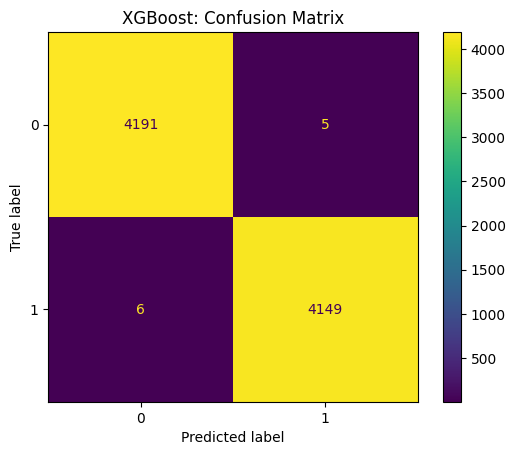

In [ ]:
# Calculate predictions on the test dataset
y_pred = xgb_cv.best_estimator_.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = xgb_cv.best_estimator_.classes_)

# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = xgb_cv.best_estimator_.classes_)
disp.plot()
plt.title('XGBoost: Confusion Matrix')

# Save to file
plt.savefig("xgboost - confusion matrix.png", dpi=300)

# Show the plot
plt.show()

The results on the test dataset confirm the exceptionally strong performance of the XGBoost ensemble classification model. Accuracy, precision, recall, and $F_1$ score are all approximately **0.998** (or **99.8%**), indicating robust generalisation and high reliability when the model is applied to previously unseen data. Furthermore, performance is consistent across both the *news* and *politics* domains, with only negligible variation observed.

### 4.6 Retrain Champion Model

To maximise predictive performance, we retrain the XGBoost ensemble model on the entire dataset using the optimal hyperparameters identified earlier.

In [ ]:
%%time
# Instantiate the champion model with best parameters
xgb_final = XGBClassifier(**xgb_cv.best_params_)

# Fit to the full dataset
xgb_final.fit(X, y)

CPU times: user 1min 40s, sys: 4.3 s, total: 1min 44s
Wall time: 23.1 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Pickle the final model
with open('xgb_final.pickle', 'wb') as to_write:
    pickle.dump(xgb_final, to_write)

## 5 Conclusion

This project successfully developed and evaluated a machine learning model for classifying news articles as fake or real. Among the models tested, the XGBoost ensemble emerged as the most effective, consistently achieving high performance across multiple evaluation metrics, including an $F_1$ score of **0.998** on the test dataset.

Feature importance analysis revealed that both engineered and Bag of Words features contributed meaningfully to the model’s performance. However, the prominence of dataset-specific artefacts highlighted the risk of overfitting to idiosyncrasies within the training data. After removing such features, the model maintained high performance, suggesting improved generalisability.

While the results are promising, further evaluation on more diverse and representative datasets is required before deploying the model in a real-world setting. Future work may also include exploring more sophisticated text vectorisation approaches, such as word embeddings or transformer-based models, and evaluating other advanced classifiers, including Support Vector Machines (SVM), to assess their comparative performance.

## 6 References
* Karim, A., et al. (2024), *Strengthening Fake News Detection: Leveraging SVM and Sophisticated Text Vectorization Techniques. Defying BERT?* arXiv preprint [arXiv:2411.12703](https://arxiv.org/abs/2411.12703)